In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
import pickle
%matplotlib inline
plt.style.use('default')
line_markers = ['-.','-,','-o','-v','-^','-<','->','-1','-2','-3','-4','-s','-p','-*','-h','-H','-+','-x','-D','-d','-|','-_']
line_markers = ['*','h','<','4','x','d','|','_']

root = './'

In [2]:
def overall_accuracy(result_dict, name_dict, dataset = 'Imagenet'):
    
    color_arr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    if dataset == 'Imagenet':
        classes = 1000
    elif dataset == 'Landmark-1K':
        classes = 1000
    elif dataset == 'Landmark-10K':
        classes = 10000

    fontsize=10
    
    fig = plt.figure(figsize = (20,5))
    
    plot_title = ['Test Top-1 Accuracy', 'Test Top-5 Accuracy']
    ax_top_1 = fig.add_subplot(141)
    ax_top_5 = fig.add_subplot(142)
        
    for idx, key in enumerate(result_dict.keys()):
        result = result_dict[key]
        tasknum = result['task_accuracy'].shape[0]
        step_size = classes // tasknum
        class_array = list(range(step_size,classes+1,step_size))[:len(result['test-top-1'])]
        top_1 = result['test-top-1']
        top_5 = result['test-top-5']

        acc_avg_1 = sum(top_1) / len(result['test-top-1'])
        acc_avg_5 = sum(top_5) / len(result['test-top-5'])

        ax_top_1.plot(class_array, top_1, linestyle='-', 
                 label=name_dict[key]+' (%.1f)'%(acc_avg_1),marker = line_markers[idx], 
                 color = color_arr[idx], linewidth=3, markersize=10)
        
        ax_top_5.plot(class_array, top_5, linestyle='-', 
                 label=name_dict[key]+' (%.1f)'%(acc_avg_5),marker = line_markers[idx], 
                 color = color_arr[idx], linewidth=3, markersize=10)


    ax_top_1.set_ylim(0,100)
    ax_top_5.set_ylim(0,100)
    ax_top_1.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
    ax_top_5.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
#     ax_top_1.set_xticks((np.arange(tasknum)+1) * step_size)
#     ax_top_5.set_xticks((np.arange(tasknum)+1) * step_size)
    ax_top_1.grid(b=True, which='major', axis='both')
    ax_top_5.grid(b=True, which='major', axis='both')
    ax_top_1.set_xlabel('classes', fontsize=fontsize)
    ax_top_5.set_xlabel('classes', fontsize=fontsize)
    ax_top_1.set_title('Top-1')
    ax_top_5.set_title('Top-5')
    ax_top_1.legend(loc='lower left', fontsize=fontsize)
    ax_top_5.legend(loc='lower left', fontsize=fontsize)

    ax = fig.add_subplot(143)
    for idx,key in enumerate(result_dict.keys()):
        result = result_dict[key]
        tasknum = result['task_accuracy'].shape[0]
        step_size = classes // tasknum
        class_array = list(range(step_size,classes+1,step_size))[:len(result['task_accuracy'])]
        acc = []
        for i in range(tasknum):
            acc.append(result['task_accuracy'][i,:i+1].mean())
        ax.plot(class_array, acc, linestyle='-', label=name_dict[key],marker = line_markers[idx], linewidth=3, markersize=10)
    
    ax.set_ylim(0,100)
    ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])
#     ax.set_xticks((np.arange(tasknum)+1) * step_size)
    ax.grid(b=True, which='major', axis='both')
    ax.set_xlabel('classes', fontsize=fontsize)
    ax.set_title('State-specific-accuracy')
    ax.legend(loc='lower left', fontsize=fontsize)
    
    ax = fig.add_subplot(144)
    for idx, key in enumerate(result_dict.keys()):
        result = result_dict[key]
        tasknum = result['task_accuracy'].shape[0]
        res_len = len(result['statistics'])
        step_size = classes // tasknum
        class_array = list(range(step_size,classes+1,step_size))[:len(result['task_accuracy'])]
        enp_arr = []
        epn_arr = []
        for t in range(res_len):
            stat = result['statistics'][t]
            cp, epp, epn, cn, enn, enp = stat['cp'], stat['epp'], stat['epn'], stat['cn'], stat['enn'], stat['enp']
        
            epn_arr.append(epn / (cp + epp + epn))
            enp_arr.append(enp / (cn + enn + enp))
        
        ax.plot(np.arange(2,res_len+2)*step_size, enp_arr, linestyle='-', label=name_dict[key], marker = line_markers[idx], linewidth=3, markersize=10, color = color_arr[idx])
        ax.plot(np.arange(2,res_len+2)*step_size, epn_arr, linestyle='--', marker = line_markers[idx], linewidth=3, markersize=10, color = color_arr[idx])
        enp_legend, = ax.plot(np.arange(2,res_len+2)*step_size, np.zeros(res_len)-1, linestyle='-', linewidth=3, color = '#7f7f7f')
        epn_legend, = ax.plot(np.arange(2,res_len+2)*step_size, np.zeros(res_len)-1, linestyle='--', linewidth=3, color = '#7f7f7f')
        
    ax.set_ylim(0,1)
#     ax.set_xticks(np.arange(2,res_len+2)*step_size)
    ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax.grid(b=True, which='major', axis='both')
    ax.set_xlabel('Classes', fontsize=fontsize)
    ax.set_title('epn Ratio & enp Ratio', fontsize=fontsize)
    leg1 = ax.legend(bbox_to_anchor=(0, 1.1, 1,.102), loc=3, ncol=4, mode='expand', borderaxespad=0., frameon = True, fontsize = fontsize)
    leg2 = ax.legend([enp_legend, epn_legend], [r'$e(n,p)$', r'$e(p,n)$'], loc='upper left', fontsize=20)
    ax.add_artist(leg1)
    plt.tight_layout()

[86.8  81.58 76.32 70.9  67.67 65.27 62.51 59.84  0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]
[97.36 94.96 92.83 90.64 89.29 87.47 86.12 84.52  0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]


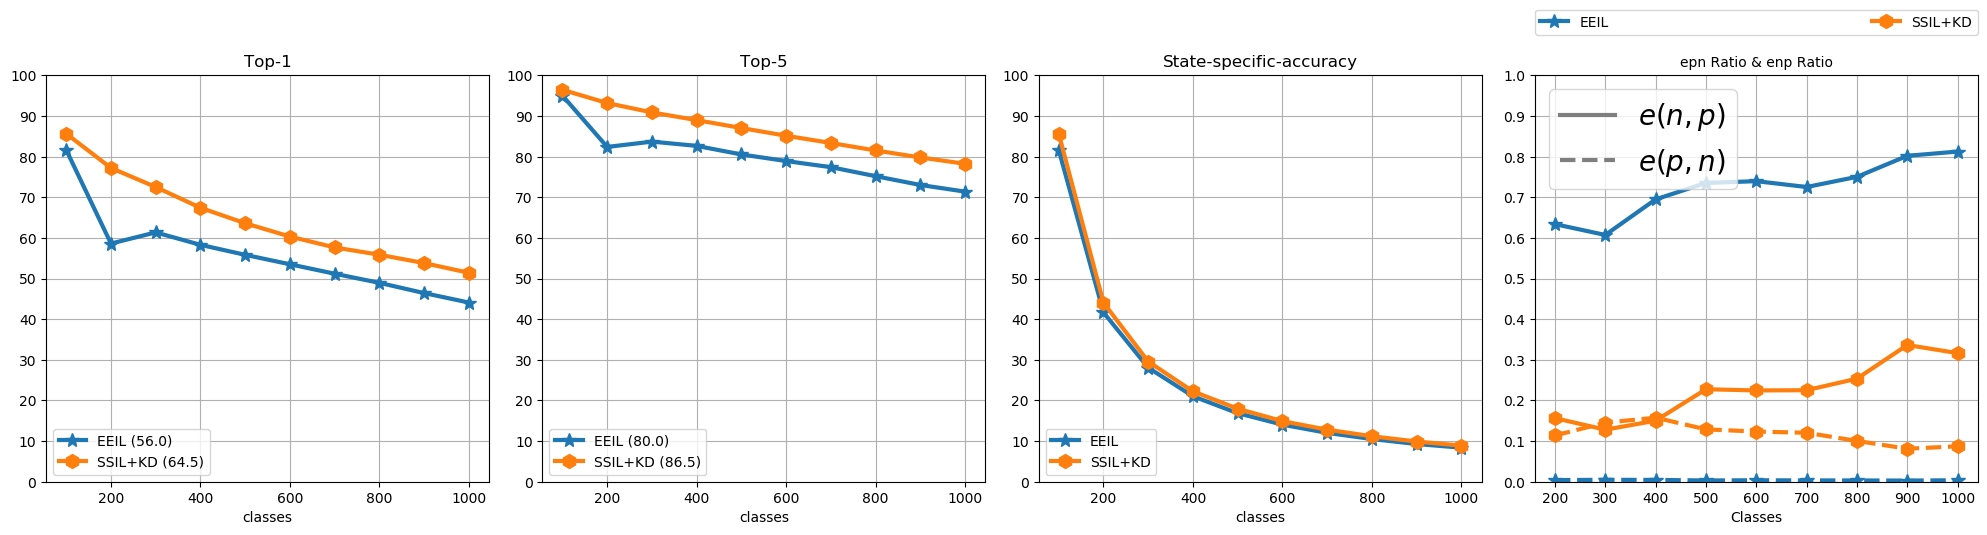

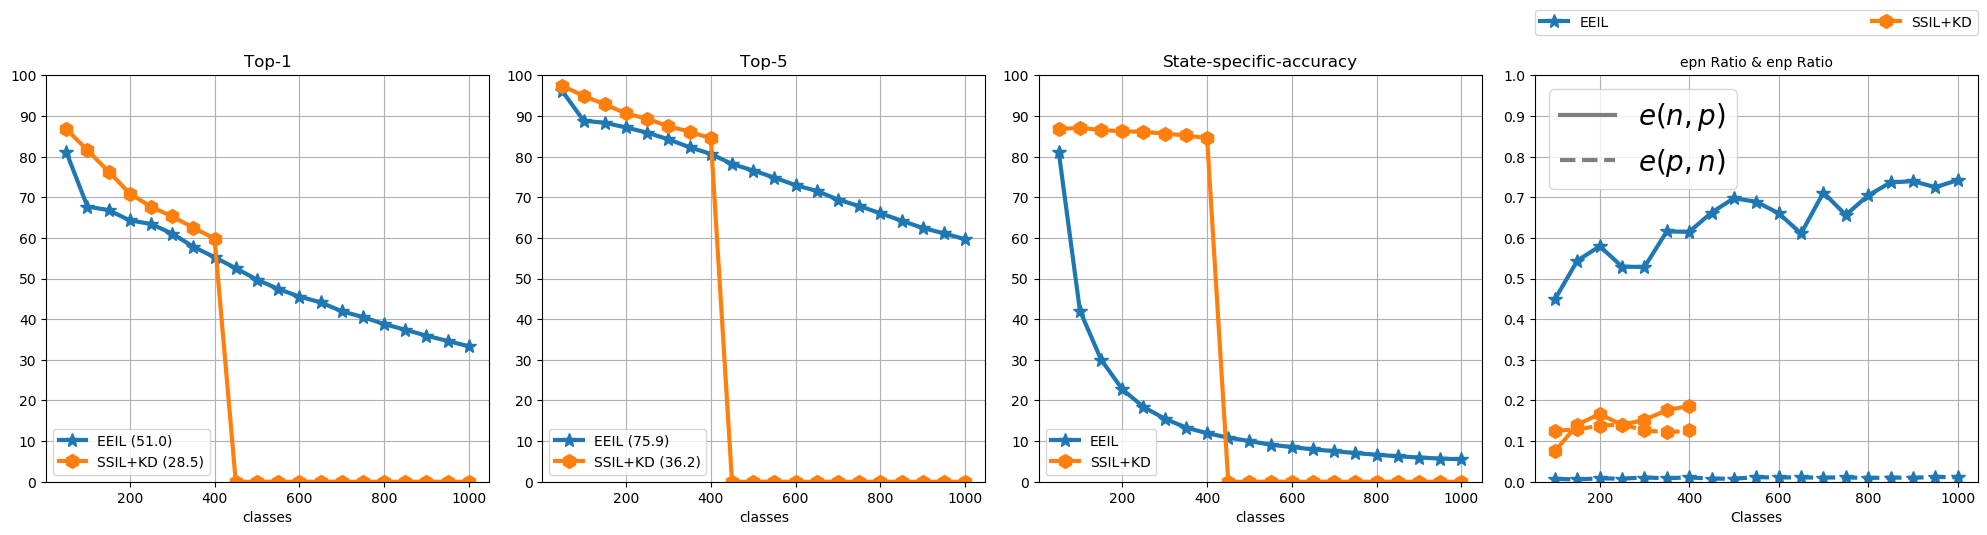

In [6]:
name_dict = {'eeil':'EEIL', 'ssil':'SSIL+KD'}
file_dict = {}

trainer_arr = ['eeil','ssil']
# mem_step_arr = [(10000,50),(10000,100),(10000,200),(5000,100),(20000,100)]
mem_step_arr = [(20000,100), (10000,50)]
rep_batch = {}
rep_batch[50], rep_batch[100], rep_batch[200] = 16, 32, 64

file_dict['eeil'] = 'CVPR_Imagenet_eeil_0_memsz_{}_base_{}_step_{}_batch_128_epoch_40.pkl'
file_dict['ssil'] = 'CVPR_Imagenet_ssil_0_memsz_{}_base_{}_step_{}_batch_128_epoch_100_replay_{}_factor_1.pkl'

for mem, step in mem_step_arr:
    result_dict = {}
    for key in file_dict.keys():
    
        if key == 'ssil':
            replay_batch = rep_batch[step]
            file = file_dict[key].format(mem, step, step, replay_batch)
        elif key == 'er':
            replay_batch = rep_batch[step]
            file = file_dict[key].format(mem, step, replay_batch)
        else:
            file = file_dict[key].format(mem, step, step)
        with (open(file, "rb")) as openfile: 
            result_dict[key] = pickle.load(openfile)

    overall_accuracy(result_dict, name_dict, dataset = 'Imagenet')

print(result_dict['ssil']['test-top-1'])
print(result_dict['ssil']['test-top-5'])

# res = result_dict['eeil']['statistics']
# print('cp \t epp \t epn \t cn \t enn \t enp')
# for i in range(9):
#     cp, epp, epn, cn, enn, enp = res[i]['cp'], res[i]['epp'], res[i]['epn'], res[i]['cn'], res[i]['enn'], res[i]['enp']
#     print('%d \t %d \t %d \t %d \t %d \t %d'%(cp, epp, epn, cn, enn, enp))
